In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import random
from datetime import timedelta
from pandas.tseries.offsets import DateOffset

In [2]:
file_path = 'BTCUSDT.csv'
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

train_start = '2020-01-01 00:00:00'
train_end   = '2020-08-30 23:59:00'
test_start  = '2020-09-01 00:00:00'
test_end    = '2021-07-30 23:59:00'

train_data = data.loc[train_start:train_end]
test_data  = data.loc[test_start:test_end]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['open']])
test_scaled  = scaler.transform(test_data[['open']])

train_torch = torch.tensor(train_scaled, dtype=torch.float32)
test_torch  = torch.tensor(test_scaled,  dtype=torch.float32)

/tmp/ipykernel_6446/4068834835.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
def create_sequences(data_tensor, seq_length):
    sequences = []
    for i in range(len(data_tensor) - seq_length):
        seq = data_tensor[i:i + seq_length]
        sequences.append(seq)
    return torch.stack(sequences)

sequence_length = 30
test_dates = test_data.index[sequence_length:]
train_sequences = create_sequences(train_torch, sequence_length)
test_sequences  = create_sequences(test_torch, sequence_length)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32, 16]):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        curr_size = input_size
        for hd in hidden_dims:
            encoder_layers.append(nn.Linear(curr_size, hd))
            encoder_layers.append(nn.ReLU())
            curr_size = hd
        
        # Decoder
        decoder_layers = []
        hidden_dims.reverse()
        for hd in hidden_dims[1:]:
            decoder_layers.append(nn.Linear(curr_size, hd))
            decoder_layers.append(nn.ReLU())
            curr_size = hd
        
        decoder_layers.append(nn.Linear(curr_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)      #(batch_size, seq_length*features) flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), -1)  # reshape back
        return decoded

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  
        return out

In [6]:
class CNNModel(nn.Module):
    """
    CNN-based model for reconstruction-based anomaly detection.
    """
    def __init__(self, input_size, out_channels=16, kernel_size=3):
        super(CNNModel, self).__init__()
        # 1 feature, channel=1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        # Flatten -> fully connected -> reshape
        self.fc = nn.Linear(out_channels * input_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, 1) 
        x = x.transpose(1, 2)   # shape: (batch_size, 1, seq_len)
        x = self.conv1(x)       # (batch_size, out_channels, seq_len)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1)  # flatten to (batch_size, out_channels * seq_len)
        x = self.fc(x)             # (batch_size, input_size)
        return x.unsqueeze(-1)     # (batch_size, input_size, 1)


In [7]:
class StackVAEG(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32], latent_dim=16):
        super(StackVAEG, self).__init__()
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        in_dim = self.input_size
        for hdim in self.hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, hdim))
            encoder_layers.append(nn.ReLU())
            in_dim = hdim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(in_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(in_dim, self.latent_dim)
        
        # Decoder
        decoder_layers = []
        out_dim = self.hidden_dims[-1]
        decoder_layers.append(nn.Linear(self.latent_dim, out_dim))
        decoder_layers.append(nn.ReLU())
        for hdim in reversed(self.hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(out_dim, hdim))
            decoder_layers.append(nn.ReLU())
            out_dim = hdim
        decoder_layers.append(nn.Linear(out_dim, self.input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        
        return reconstructed.view(x.size(0), -1), mu, logvar

In [8]:
class OmniAnomaly(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, latent_dim=16, num_layers=1):
        super(OmniAnomaly, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # LSTM Encoder
        self.lstm_enc = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # LSTM Decoder
        self.lstm_dec = nn.LSTM(latent_dim, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        enc_out, _ = self.lstm_enc(x)  
        mu = self.fc_mu(enc_out)       # (batch_size, seq_len, latent_dim)
        logvar = self.fc_logvar(enc_out)
        
        z = self.reparameterize(mu, logvar)  # (batch_size, seq_len, latent_dim)
        
        dec_out, _ = self.lstm_dec(z)
        reconstructed = self.fc_out(dec_out)  # (batch_size, seq_len, input_size)
        
        return reconstructed, mu, logvar

In [9]:
class EGADSModel:
    def __init__(self, window=30):
        self.window = window
        self.train_length_ = None

    def fit(self, data):
        data = data.flatten()
        self.train_length_ = len(data)
        
    def predict(self, data):
        data = data.flatten()
        full_series = pd.Series(data)
        
        roll_mean = full_series.rolling(self.window, min_periods=1).mean()
        roll_std = full_series.rolling(self.window, min_periods=1).std()

        roll_std = roll_std.fillna(1e-8)

        z_scores = np.abs(data - roll_mean) / roll_std
        
        anomaly_scores = z_scores.to_numpy()  
        print(len(data))
        print(len(anomaly_scores))
        return anomaly_scores

In [10]:
class DTWModel:
    def __init__(self, window=30, n_references=10, seed=42):
        self.window = window
        self.n_references = n_references
        self.references = []
        self.seed = seed
    
    def fit(self, train_sequences):
        np.random.seed(self.seed)
        total_sequences = train_sequences.shape[0]
        selected_indices = np.random.choice(total_sequences, self.n_references, replace=False)
        self.references = [train_sequences[i].squeeze().numpy() for i in selected_indices]
        print(f"DTWModel: Selected {self.n_references} reference sequences.")
    
    def predict(self, test_sequences):
        scores = []
        for seq in test_sequences:
            seq_np = seq.squeeze().numpy()
            distances = [dtw.distance(seq_np, ref) for ref in self.references]
            min_distance = min(distances)
            scores.append(min_distance)
        return np.array(scores)

In [11]:
class AnomalyDetector:
    def __init__(self, model_name, model_params, sequence_length=30, device='cpu'):
        self.model_name = model_name.lower()
        self.model_params = model_params
        self.sequence_length = sequence_length
        self.device = device
        
        if self.model_name == 'egads':
            self.model = EGADSModel(**self.model_params)
        elif self.model_name == 'dtw':
            self.model = DTWModel(**self.model_params)
        else:
            self.model = self._initialize_model().to(self.device)
        
    def _initialize_model(self):
        if self.model_name == 'autoencoder':
            return Autoencoder(**self.model_params)
        elif self.model_name == 'lstm':
            return LSTMModel(**self.model_params)
        elif self.model_name == 'cnn':
            return CNNModel(**self.model_params)
        elif self.model_name == 'stackvaeg':
            return StackVAEG(**self.model_params)
        elif self.model_name == 'omnianomaly':
            return OmniAnomaly(**self.model_params)
        else:
            raise ValueError(f"Unknown model_name: {self.model_name}")
    
    def train(self, train_sequences=None, num_epochs=10, batch_size=32, learning_rate=1e-3, train_raw=None):
        if self.model_name == 'egads':
            if train_raw is None:
                raise ValueError("EGADS requires 'train_raw'")
            data_np = train_raw.cpu().numpy().flatten()
            self.model.fit(data_np)
            return
        elif self.model_name == 'dtw':
            if train_sequences is None:
                raise ValueError("DTW requires 'train_sequences'")
            self.model.fit(train_sequences)
            return
        
        if train_sequences is None:
            raise ValueError(f"{self.model_name} requires 'train_sequences'")
        
        train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc=f"Training {self.model_name}"):
            running_loss = 0.0
            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, mu, logvar = self.model(batch)
                        batch_flat = batch.view(batch.size(0), -1)
                        recon_loss = nn.MSELoss()(outputs, batch_flat)
                    else:  
                        reconstructed, mu, logvar = self.model(batch)
                        recon_loss = nn.MSELoss()(reconstructed, batch)
                    # KLD
                    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + kld * 0.001
                else:
                    outputs = self.model(batch)
                    if self.model_name == 'cnn':
                        loss = nn.MSELoss()(outputs, batch.view_as(outputs))
                    elif self.model_name == 'lstm':
                        loss = nn.MSELoss()(outputs, batch)
                    else:
                        loss = nn.MSELoss()(outputs, batch.view(outputs.size()))
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, test_sequences=None, test_raw=None):
        if self.model_name == 'egads':
            if test_raw is None:
                raise ValueError("EGADS requires 'test_raw'")
            scores = self.model.predict(test_raw.cpu().numpy().flatten())
            return scores
        elif self.model_name == 'dtw':
            if test_sequences is None:
                raise ValueError("DTW requires 'test_sequences'")
            scores = self.model.predict(test_sequences)
            return scores
        
        self.model.eval()
        all_errors = []
        with torch.no_grad():
            for i in range(len(test_sequences)):
                x = test_sequences[i].unsqueeze(0).to(self.device)
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, _, _ = self.model(x)
                        target = x.view(1, -1)
                        mse = torch.mean((outputs - target) ** 2, dim=1)
                    else:
                        reconstructed, _, _ = self.model(x)
                        mse = torch.mean((reconstructed - x) ** 2, dim=[1,2])
                else:
                    outputs = self.model(x)
                    if self.model_name == 'cnn':
                        mse = torch.mean((outputs - x.view_as(outputs)) ** 2, dim=[1,2])
                    elif self.model_name == 'lstm':
                        mse = torch.mean((outputs - x) ** 2, dim=[1,2])
                    else:
                        # autoencoder
                        mse = torch.mean((outputs - x.view(1, -1)) ** 2, dim=1)
                all_errors.append(mse.item())
        return np.array(all_errors)
    
    def get_anomalies(self, errors, percentile=99.5):
        threshold = np.percentile(errors, percentile)
        anomalies = errors > threshold
        return anomalies, threshold


In [12]:
def merge_anomaly_clusters(clusters, merge_threshold_minutes):
    if not clusters:
        return []
    
    sorted_clusters = sorted(clusters, key=lambda x: x[0])
    merged = [sorted_clusters[0]]
    
    for current_start, current_end in sorted_clusters[1:]:
        last_start, last_end = merged[-1]
        gap = (current_start - last_end).total_seconds() / 60.0  # gap in minutes
        
        if gap <= merge_threshold_minutes:
            merged[-1] = (last_start, max(last_end, current_end))
        else:
            merged.append((current_start, current_end))
    
    return merged

def simulate_trading_with_clusters(model_name, merged_clusters, price_data, ma_data, window_minutes):
    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital  
    
    for cluster in merged_clusters:
        anomaly_end_time = cluster[1]
        
        if anomaly_end_time not in price_data.index or anomaly_end_time not in ma_data.index:
            print(f"Anomaly end time {anomaly_end_time} not in data. Skipping trade.")
            continue  
        
        current_price = price_data.loc[anomaly_end_time]
        current_ma = ma_data.loc[anomaly_end_time]
        
        if current_price > current_ma:
            trade_type = 'sell'
        elif current_price < current_ma:
            trade_type = 'buy'
        else:
            print(f"Price equals MA at {anomaly_end_time}. No trade executed.")
            continue  
        
        trade_amount = 0.1 * capital  
        trade_entry_price = current_price
        
        trade_exit_time = None
        for timestamp in price_data.loc[anomaly_end_time:].index:
            if timestamp not in ma_data.index:
                continue  
            
            current_price = price_data.loc[timestamp]
            current_ma = ma_data.loc[timestamp]
            
            if trade_type == 'buy' and current_price >= current_ma:
                trade_exit_time = timestamp
                exit_price = current_price
                break
            elif trade_type == 'sell' and current_price <= current_ma:
                trade_exit_time = timestamp
                exit_price = current_price
                break
        
        if trade_exit_time is None:
            print(f"No suitable exit found for trade starting at {anomaly_end_time}. Skipping trade.")
            continue
        
        if trade_type == 'buy':
            profit = (exit_price - trade_entry_price) * (trade_amount / trade_entry_price)
        elif trade_type == 'sell':
            profit = (trade_entry_price - exit_price) * (trade_amount / trade_entry_price)
        
        capital += profit
        
        mask = (capital_history.index >= anomaly_end_time) & (capital_history.index <= trade_exit_time)
        capital_history.loc[mask] = capital
        
        if trade_exit_time < capital_history.index[-1]:
            capital_history.loc[trade_exit_time:] = capital
    
    capital_history.ffill(inplace=True)
    
    capital_history.fillna(capital, inplace=True)
    
    return capital_history


In [32]:
window_days = 144
window_minutes = window_days * 24 * 60  

original_data_sorted = data[['open', 'close']].copy().sort_index()

original_data_sorted['rolling_avg'] = original_data_sorted['open'].rolling(window=window_minutes).mean()
original_data_sorted['rolling_low'] = original_data_sorted['open'].rolling(window=window_minutes).min()
original_data_sorted['rolling_high'] = original_data_sorted['open'].rolling(window=window_minutes).max()


def analyze_anomalies(anomaly_timestamps, original_data_sorted, window_minutes=13*24*60):
    results = []
    
    for ts in anomaly_timestamps:
        if ts < original_data_sorted.index[window_minutes-1]:
            continue
        
        future_time = ts + pd.Timedelta(hours=1)
        if future_time > original_data_sorted.index[-1]:
            continue
        
        try:
            open_price = original_data_sorted.loc[ts, 'open']
        except KeyError:
            continue
        
        prev_time = ts - pd.Timedelta(minutes=1)
        if prev_time not in original_data_sorted.index:
            continue
        rolling_avg = original_data_sorted.loc[prev_time, 'rolling_avg']
        rolling_low = original_data_sorted.loc[prev_time, 'rolling_low']
        rolling_high = original_data_sorted.loc[prev_time, 'rolling_high']
        
        if np.isnan(rolling_avg) or np.isnan(rolling_low) or np.isnan(rolling_high):
            continue
        
        above_avg = open_price > rolling_avg
        
        above_low = open_price > rolling_low
        below_high = open_price < rolling_high
        
        try:
            next_hour_data = original_data_sorted.loc[ts + pd.Timedelta(minutes=1): ts + pd.Timedelta(hours=1)]
        except KeyError:
            continue
        
        if next_hour_data.empty:
            continue
        
        min_open_next_hour = next_hour_data['open'].min()
        max_open_next_hour = next_hour_data['open'].max()
        
        try:
            close_price_next_hour = original_data_sorted.loc[ts + pd.Timedelta(hours=1), 'close']
        except KeyError:
            continue
        
        if above_avg:
            price_after = min_open_next_hour
            price_change = min_open_next_hour - open_price
            direction = 'Min'
        else:
            price_after = max_open_next_hour
            price_change = max_open_next_hour - open_price
            direction = 'Max'
        
        close_change = close_price_next_hour - open_price
        
        price_change_pct = (price_change / open_price) * 100
        close_change_pct = (close_change / open_price) * 100
        
        if above_avg:
            if price_after < open_price:
                sign = 1  
            elif price_after > open_price:
                sign = -1  
            else:
                sign = 0
        else:
            if price_after > open_price:
                sign = 1  
            elif price_after < open_price:
                sign = -1  
            else:
                sign = 0
        
        price_change_pct_signed = price_change_pct * sign
        close_change_pct_signed = close_change_pct * sign
        
        relative_to_avg = 'Above Avg' if above_avg else 'Below Avg'
        relative_to_low_high = []
        if above_low:
            relative_to_low_high.append('Above Low')
        if below_high:
            relative_to_low_high.append('Below High')
        if not relative_to_low_high:
            relative_to_low_high.append('At Low/High')  
        
        results.append({
            'timestamp': ts,
            'open_price': open_price,
            'rolling_avg': rolling_avg,
            'rolling_low': rolling_low,
            'rolling_high': rolling_high,
            'relative_to_avg': relative_to_avg,
            'relative_to_low_high': ', '.join(relative_to_low_high),
            'price_after': price_after,
            'price_change_pct_signed': price_change_pct_signed,
            'direction': direction,
            'close_next_hour': close_price_next_hour,
            'close_change_pct_signed': close_change_pct_signed
        })
    
    results_df = pd.DataFrame(results)
    return results_df

def compute_statistics(results_df, model_name):
    if results_df.empty:
        print("No anomalies to analyze.")
        return
    
    print(f"\n=== Statistics for {model_name.capitalize()} ===")
    
    relative_to_avg = results_df['relative_to_avg']
    print(f"\nRelative to {window_days}-day Average:")
    print(relative_to_avg.value_counts())
    
    relative_to_low_high = results_df['relative_to_low_high']
    print(f"\nRelative to {window_days}-day Low/High:")
    print(relative_to_low_high.value_counts())
    
    print("\nNext Hour Min/Max Open Price Change (%):")
    print(results_df['price_change_pct_signed'].describe())
    
    print("\nNext Hour Close Price Change (%):")
    print(results_df['close_change_pct_signed'].describe())
    
    plt.figure(figsize=(10, 5))
    relative_to_avg.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_days}-day Average')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    relative_to_low_high.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_days}-day Low/High')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['price_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Min/Max Open Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['close_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Close Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()

In [33]:
#model_names = ['autoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads'] ######
model_names = ['autoencoder', 'stackvaeg', 'egads']
model_params = {
    'autoencoder': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32, 16]
    },
    'lstm': {
        'input_size': 1,     
        'hidden_size': 32,
        'num_layers': 1
    },
    'cnn': {
        'input_size': sequence_length,
        'out_channels': 16,
        'kernel_size': 3
    },
    'stackvaeg': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32],
        'latent_dim': 16
    },
    'omnianomaly': {
        'input_size': 1,     
        'hidden_size': 32,
        'latent_dim': 16,
        'num_layers': 1
    },
    'egads': {
        'window': 30
    },
    'dtw': {
        'window': 30,
        'n_references': 10,
        'seed': 42
    }
}

In [34]:
train_initial_length = pd.DateOffset(months=4)  
train_expand_step = pd.DateOffset(months=2)    
test_length = pd.DateOffset(months=2)           

start_date = pd.Timestamp('2020-01-01 00:00:00')
end_date = pd.Timestamp('2020-08-31 23:59:00')

combined_test_dates = []      
combined_scores = {}          
combined_anomalies = {}  
original_prices_buffer = []

for model_name in model_names:
    combined_scores[model_name] = []
    combined_anomalies[model_name] = []

current_train_start = start_date
current_train_end = current_train_start + train_initial_length
current_test_start = current_train_end
current_test_end = current_test_start + test_length

In [35]:
while current_test_end <= end_date or current_test_start < end_date:
    if current_test_end > end_date:
        current_test_end = end_date
    print(f"\n=== Processing Window: Train {current_train_start} to {current_train_end}, "
          f"Test {current_test_start} to {current_test_end} ===")
    
    train_data = data.loc[current_train_start:current_train_end]
    test_data = data.loc[current_test_start:current_test_end]

    if test_data.empty:
        break
        
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data[['open']])
    test_scaled = scaler.transform(test_data[['open']])

    original_prices_buffer.extend(test_data['open'].values[sequence_length:])
    
    train_torch = torch.tensor(train_scaled, dtype=torch.float32)
    test_torch = torch.tensor(test_scaled, dtype=torch.float32)


    train_sequences = create_sequences(train_torch, sequence_length)
    test_sequences = create_sequences(test_torch, sequence_length)
    test_dates = test_data.index[sequence_length:]
    combined_test_dates.extend(test_dates)
    
    for model_name in model_names:
        print(f"\n=== Processing Model: {model_name} ===")
        
        params = model_params[model_name]
        detector = AnomalyDetector(
            model_name=model_name,
            model_params=params,
            sequence_length=sequence_length,
            device='cpu' 
        )
        
        if model_name not in ['egads', 'dtw']:
            detector.train(
                train_sequences=train_sequences,
                num_epochs=10,
                batch_size=32,
                learning_rate=1e-3
            )
        elif model_name == 'egads':
            detector.train(
                train_sequences=None,
                train_raw=train_torch
            )
        elif model_name == 'dtw':
            detector.train(
                train_sequences=train_sequences,
                num_epochs=0,
                batch_size=0,
                learning_rate=0,
                train_raw=None
            )
        
        if model_name not in ['egads', 'dtw']:
            scores = detector.predict(test_sequences=test_sequences)
        elif model_name == 'egads':
            scores = detector.predict(test_raw=test_torch)[sequence_length:]
        elif model_name == 'dtw':
            scores = detector.predict(test_sequences=test_sequences)
        
        combined_scores[model_name].extend(scores)
    
    current_train_end += train_expand_step
    current_test_start += train_expand_step
    current_test_end = current_test_start + test_length




=== Processing Window: Train 2020-01-01 00:00:00 to 2020-05-01 00:00:00, Test 2020-05-01 00:00:00 to 2020-07-01 00:00:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|██▏                   | 1/10 [00:15<02:21, 15.70s/it]

Epoch 1/10, Loss: 0.006276


Training autoencoder:  20%|████▍                 | 2/10 [00:31<02:04, 15.52s/it]

Epoch 2/10, Loss: 0.000240


Training autoencoder:  30%|██████▌               | 3/10 [00:46<01:48, 15.47s/it]

Epoch 3/10, Loss: 0.000152


Training autoencoder:  40%|████████▊             | 4/10 [01:02<01:32, 15.49s/it]

Epoch 4/10, Loss: 0.000147


Training autoencoder:  50%|███████████           | 5/10 [01:17<01:17, 15.52s/it]

Epoch 5/10, Loss: 0.000152


Training autoencoder:  60%|█████████████▏        | 6/10 [01:33<01:02, 15.58s/it]

Epoch 6/10, Loss: 0.000135


Training autoencoder:  70%|███████████████▍      | 7/10 [01:49<00:46, 15.64s/it]

Epoch 7/10, Loss: 0.000134


Training autoencoder:  80%|█████████████████▌    | 8/10 [02:04<00:31, 15.69s/it]

Epoch 8/10, Loss: 0.000132


Training autoencoder:  90%|███████████████████▊  | 9/10 [02:20<00:15, 15.71s/it]

Epoch 9/10, Loss: 0.000142


Training autoencoder: 100%|█████████████████████| 10/10 [02:36<00:00, 15.66s/it]

Epoch 10/10, Loss: 0.000131



=== Processing Model: stackvaeg ===


Training stackvaeg:  10%|██▍                     | 1/10 [00:19<02:51, 19.08s/it]

Epoch 1/10, Loss: 0.009543


Training stackvaeg:  20%|████▊                   | 2/10 [00:38<02:33, 19.17s/it]

Epoch 2/10, Loss: 0.001057


Training stackvaeg:  30%|███████▏                | 3/10 [00:57<02:14, 19.27s/it]

Epoch 3/10, Loss: 0.000776


Training stackvaeg:  40%|█████████▌              | 4/10 [01:17<01:56, 19.34s/it]

Epoch 4/10, Loss: 0.000740


Training stackvaeg:  50%|████████████            | 5/10 [01:36<01:37, 19.43s/it]

Epoch 5/10, Loss: 0.000709


Training stackvaeg:  60%|██████████████▍         | 6/10 [01:56<01:18, 19.53s/it]

Epoch 6/10, Loss: 0.000693


Training stackvaeg:  70%|████████████████▊       | 7/10 [02:16<00:59, 19.67s/it]

Epoch 7/10, Loss: 0.000686


Training stackvaeg:  80%|███████████████████▏    | 8/10 [02:36<00:39, 19.71s/it]

Epoch 8/10, Loss: 0.000677


Training stackvaeg:  90%|█████████████████████▌  | 9/10 [02:56<00:19, 19.76s/it]

Epoch 9/10, Loss: 0.000670


Training stackvaeg: 100%|███████████████████████| 10/10 [03:16<00:00, 19.62s/it]

Epoch 10/10, Loss: 0.000667



=== Processing Model: egads ===
87841
87841

=== Processing Window: Train 2020-01-01 00:00:00 to 2020-07-01 00:00:00, Test 2020-07-01 00:00:00 to 2020-08-31 23:59:00 ===

=== Processing Model: autoencoder ===


Training autoencoder:  10%|██▏                   | 1/10 [00:22<03:23, 22.56s/it]

Epoch 1/10, Loss: 0.007459


Training autoencoder:  20%|████▍                 | 2/10 [00:45<03:01, 22.69s/it]

Epoch 2/10, Loss: 0.000218


Training autoencoder:  30%|██████▌               | 3/10 [01:08<02:38, 22.71s/it]

Epoch 3/10, Loss: 0.000162


Training autoencoder:  40%|████████▊             | 4/10 [01:31<02:16, 22.82s/it]

Epoch 4/10, Loss: 0.000142


Training autoencoder:  50%|███████████           | 5/10 [01:54<01:54, 22.92s/it]

Epoch 5/10, Loss: 0.000138


Training autoencoder:  60%|█████████████▏        | 6/10 [02:17<01:31, 22.99s/it]

Epoch 6/10, Loss: 0.000130


Training autoencoder:  70%|███████████████▍      | 7/10 [02:40<01:09, 23.12s/it]

Epoch 7/10, Loss: 0.000138


Training autoencoder:  80%|█████████████████▌    | 8/10 [03:04<00:46, 23.25s/it]

Epoch 8/10, Loss: 0.000126


Training autoencoder:  90%|███████████████████▊  | 9/10 [03:27<00:23, 23.41s/it]

Epoch 9/10, Loss: 0.000124


Training autoencoder: 100%|█████████████████████| 10/10 [03:51<00:00, 23.19s/it]

Epoch 10/10, Loss: 0.000142



=== Processing Model: stackvaeg ===


Training stackvaeg:  10%|██▍                     | 1/10 [00:28<04:19, 28.85s/it]

Epoch 1/10, Loss: 0.006980


Training stackvaeg:  20%|████▊                   | 2/10 [00:58<03:52, 29.07s/it]

Epoch 2/10, Loss: 0.001020


Training stackvaeg:  30%|███████▏                | 3/10 [01:27<03:24, 29.20s/it]

Epoch 3/10, Loss: 0.000932


Training stackvaeg:  40%|█████████▌              | 4/10 [01:57<02:56, 29.36s/it]

Epoch 4/10, Loss: 0.000832


Training stackvaeg:  50%|████████████            | 5/10 [02:26<02:27, 29.53s/it]

Epoch 5/10, Loss: 0.000780


Training stackvaeg:  60%|██████████████▍         | 6/10 [02:56<01:58, 29.65s/it]

Epoch 6/10, Loss: 0.000752


Training stackvaeg:  70%|████████████████▊       | 7/10 [03:26<01:29, 29.79s/it]

Epoch 7/10, Loss: 0.000757


Training stackvaeg:  80%|███████████████████▏    | 8/10 [03:57<00:59, 29.97s/it]

Epoch 8/10, Loss: 0.000739


Training stackvaeg:  90%|█████████████████████▌  | 9/10 [04:28<00:30, 30.32s/it]

Epoch 9/10, Loss: 0.000738


Training stackvaeg: 100%|███████████████████████| 10/10 [05:01<00:00, 30.18s/it]

Epoch 10/10, Loss: 0.000855



=== Processing Model: egads ===
89280
89280



=== Final Outputs for Model: autoencoder ===


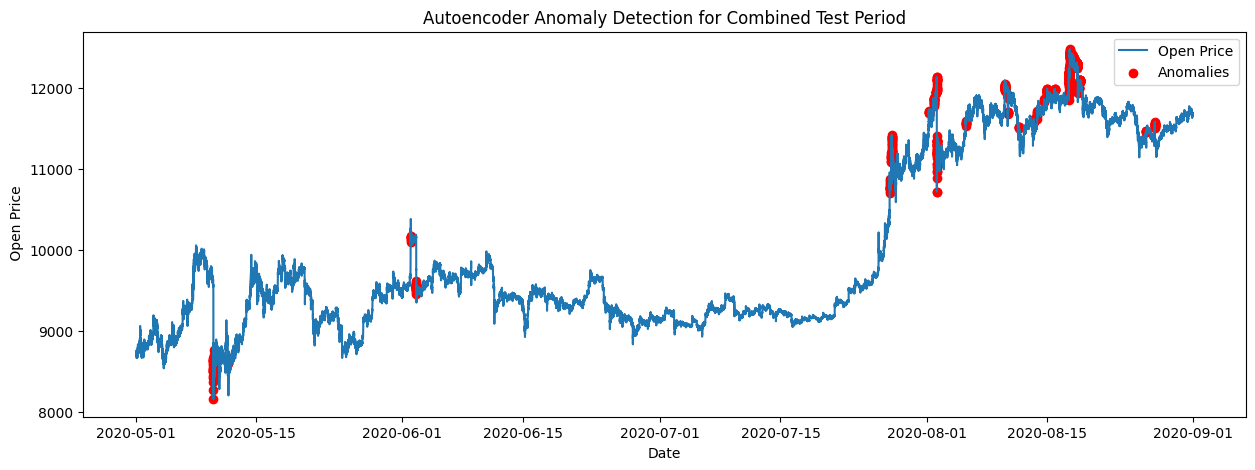


=== Statistics for Autoencoder ===

Relative to 144-day Average:
relative_to_avg
Above Avg    853
Name: count, dtype: int64

Relative to 144-day Low/High:
relative_to_low_high
Above Low, Below High    830
Above Low                 23
Name: count, dtype: int64

Next Hour Min/Max Open Price Change (%):
count    853.000000
mean      -0.803227
std        1.557949
min      -11.650548
25%       -0.752956
50%       -0.415262
75%       -0.240663
max       -0.000324
Name: price_change_pct_signed, dtype: float64

Next Hour Close Price Change (%):
count    853.000000
mean      -0.369422
std        1.077766
min       -6.972051
25%       -0.512522
50%       -0.197568
75%        0.040271
max        5.530934
Name: close_change_pct_signed, dtype: float64


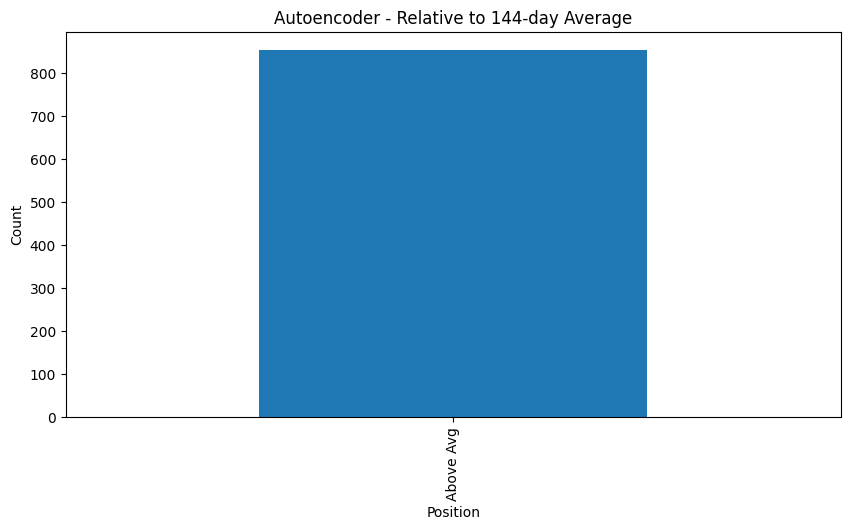

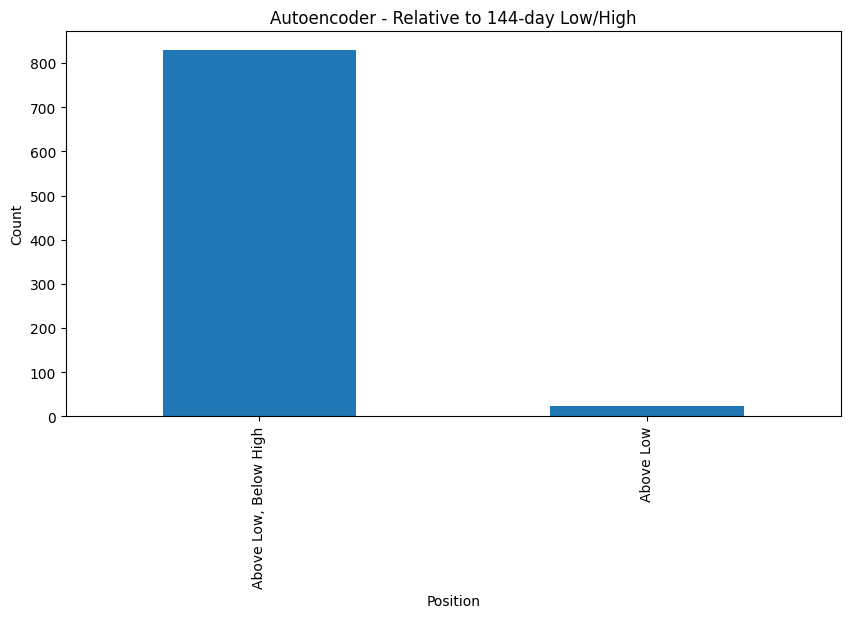

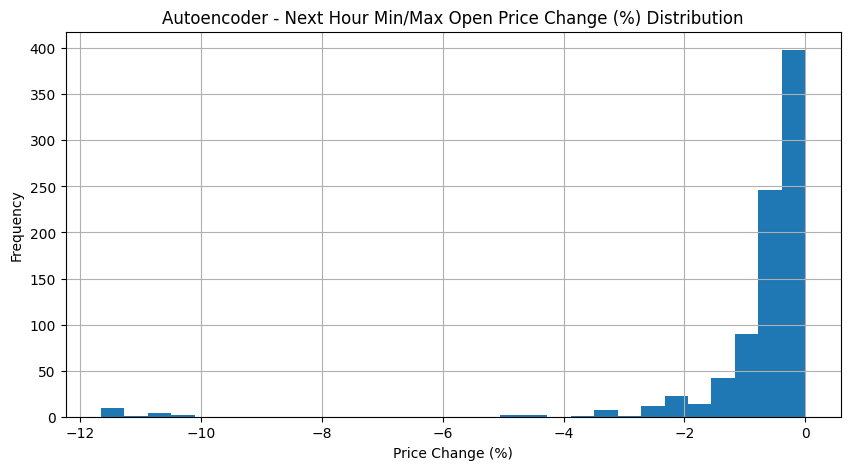

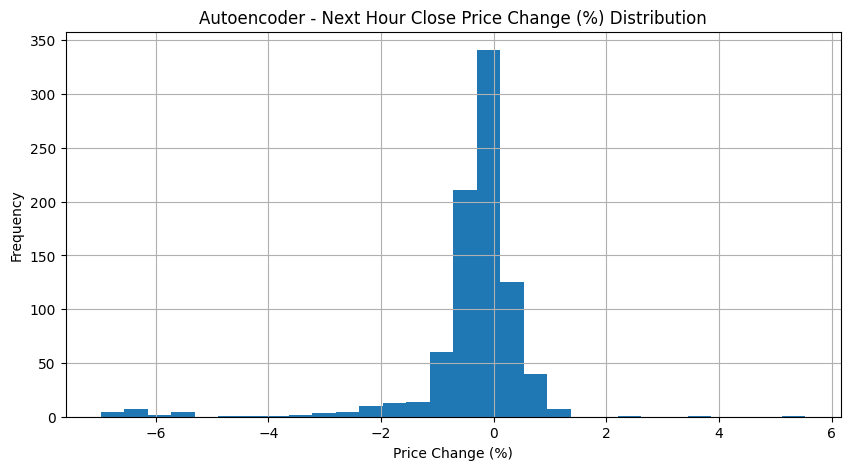

Total Merged Clusters for Trading: 35
No suitable exit found for trade starting at 2020-05-10 00:48:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-11 17:02:00. Skipping trade.
No suitable exit found for trade starting at 2020-06-01 23:31:00. Skipping trade.
No suitable exit found for trade starting at 2020-06-02 15:16:00. Skipping trade.
No suitable exit found for trade starting at 2020-07-27 17:15:00. Skipping trade.
No suitable exit found for trade starting at 2020-07-27 22:29:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-01 06:32:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-01 19:50:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-02 02:01:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-02 05:21:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-05 13:02:00. Skipping trade.
No suitable exit found for trade starting at 2020-08-10 02:3

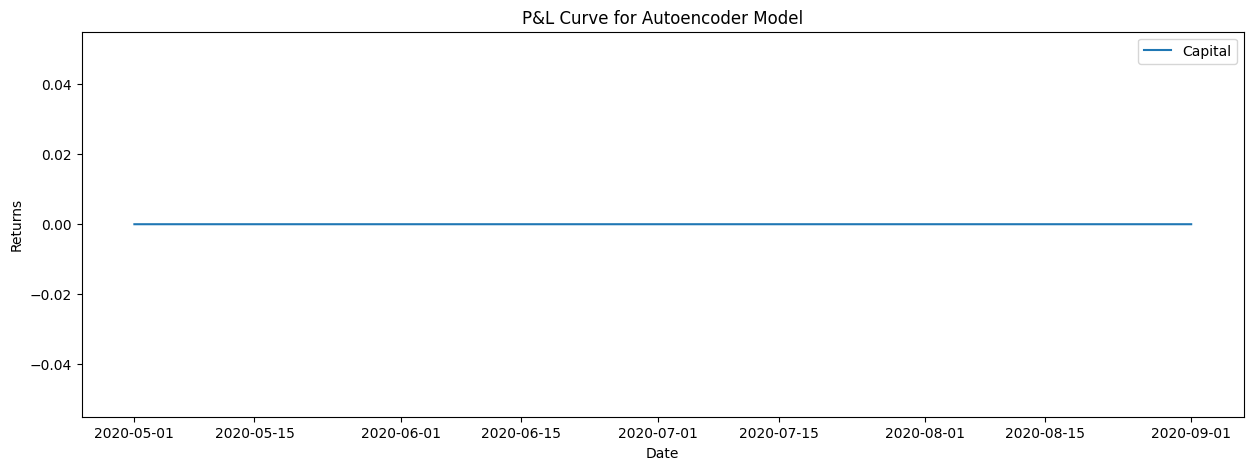

Final Capital for autoencoder: 1.0000

=== Final Outputs for Model: stackvaeg ===


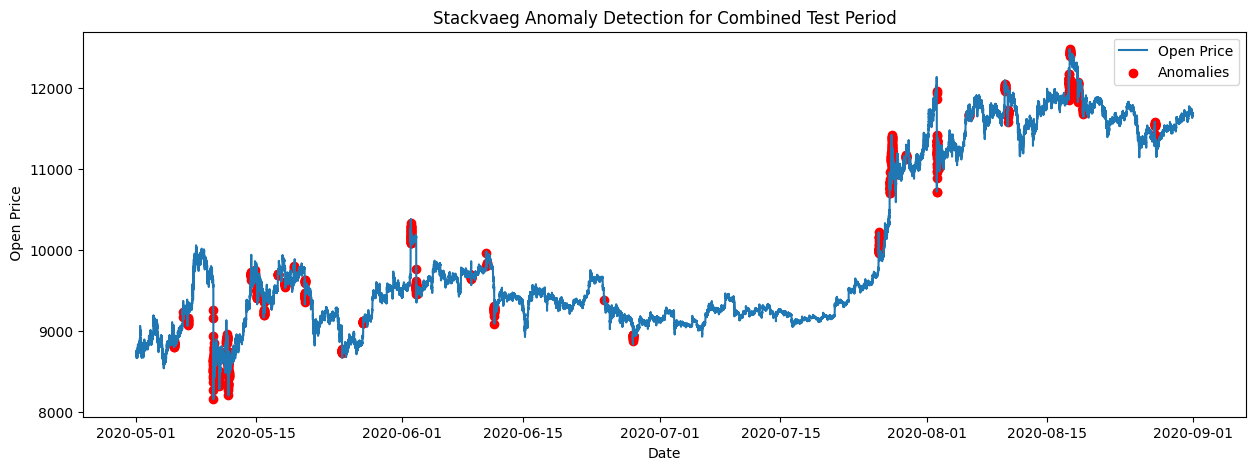


=== Statistics for Stackvaeg ===

Relative to 144-day Average:
relative_to_avg
Above Avg    546
Name: count, dtype: int64

Relative to 144-day Low/High:
relative_to_low_high
Above Low, Below High    531
Above Low                 15
Name: count, dtype: int64

Next Hour Min/Max Open Price Change (%):
count    546.000000
mean      -0.862700
std        1.187387
min      -10.348051
25%       -1.097764
50%       -0.422523
75%       -0.171647
max       -0.000661
Name: price_change_pct_signed, dtype: float64

Next Hour Close Price Change (%):
count    546.000000
mean      -0.223904
std        1.114573
min       -5.448881
25%       -0.730239
50%       -0.013602
75%        0.432462
max        5.530934
Name: close_change_pct_signed, dtype: float64


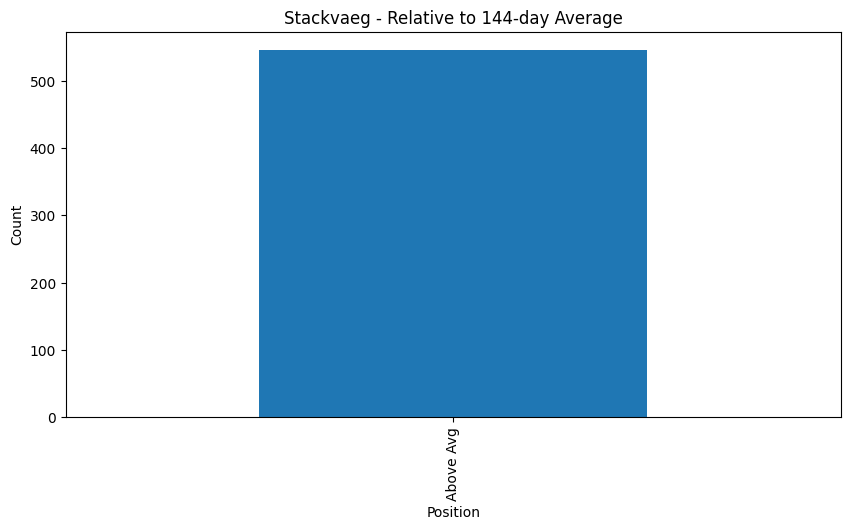

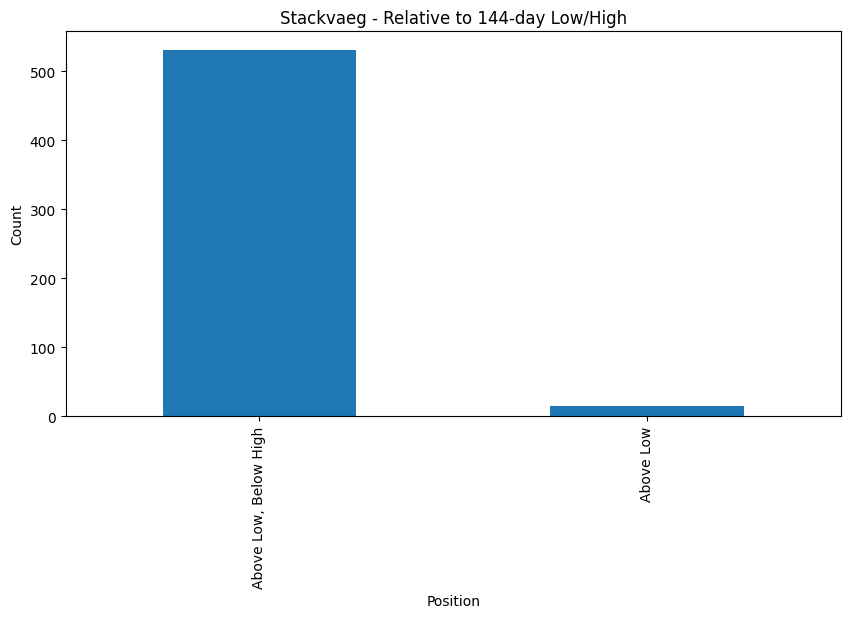

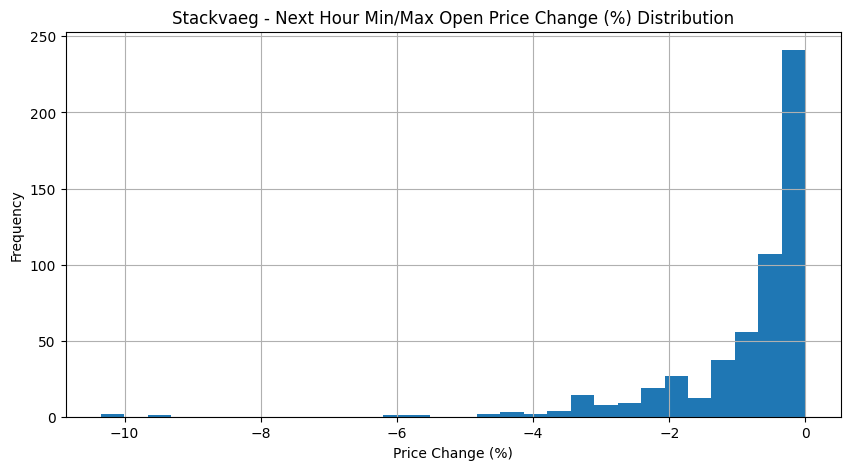

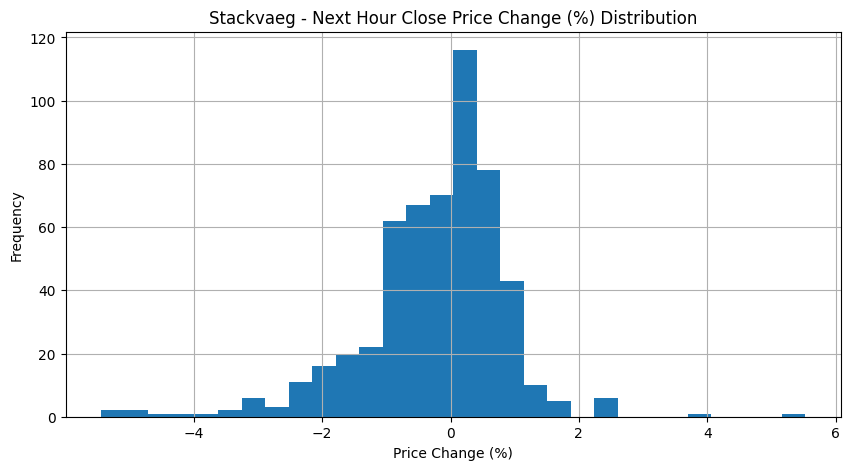

Total Merged Clusters for Trading: 42
No suitable exit found for trade starting at 2020-05-05 10:25:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-06 10:40:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-07 00:13:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-10 01:07:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-10 17:03:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-10 20:26:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-11 13:11:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-11 17:07:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-11 19:15:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-11 20:15:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-14 10:38:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-14 20:5

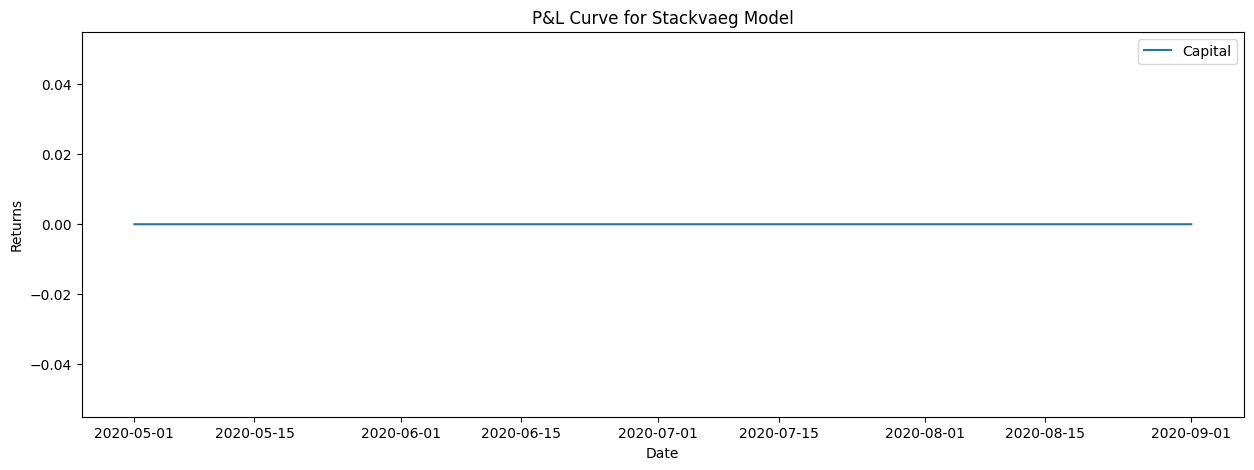

Final Capital for stackvaeg: 1.0000

=== Final Outputs for Model: egads ===


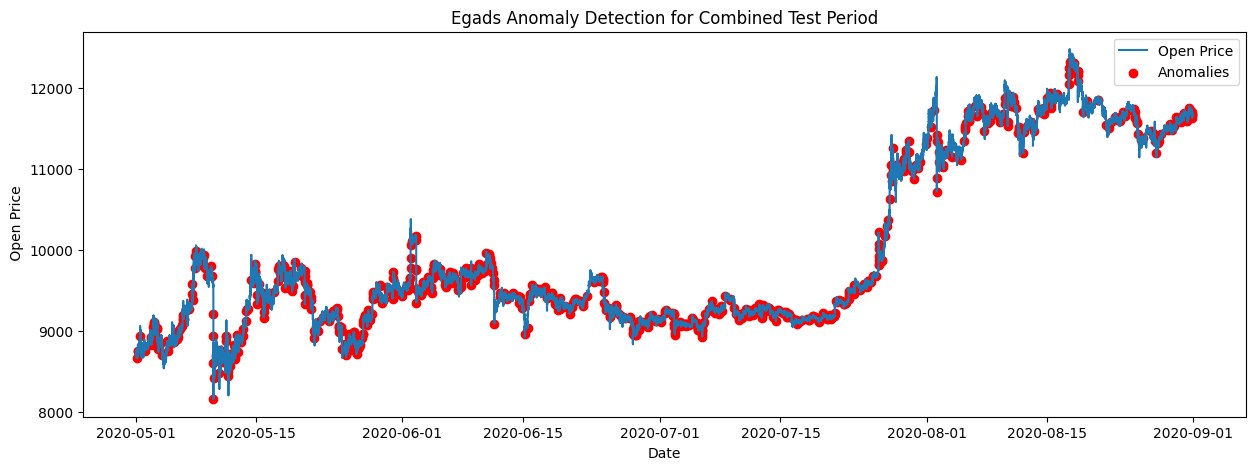


=== Statistics for Egads ===

Relative to 144-day Average:
relative_to_avg
Above Avg    712
Name: count, dtype: int64

Relative to 144-day Low/High:
relative_to_low_high
Above Low, Below High    706
Above Low                  6
Name: count, dtype: int64

Next Hour Min/Max Open Price Change (%):
count    712.000000
mean      -0.412971
std        0.664018
min       -7.571604
25%       -0.452588
50%       -0.214915
75%       -0.084742
max       -0.000340
Name: price_change_pct_signed, dtype: float64

Next Hour Close Price Change (%):
count    712.000000
mean      -0.179952
std        0.714480
min       -6.546488
25%       -0.381229
50%       -0.111855
75%        0.106588
max        5.530934
Name: close_change_pct_signed, dtype: float64


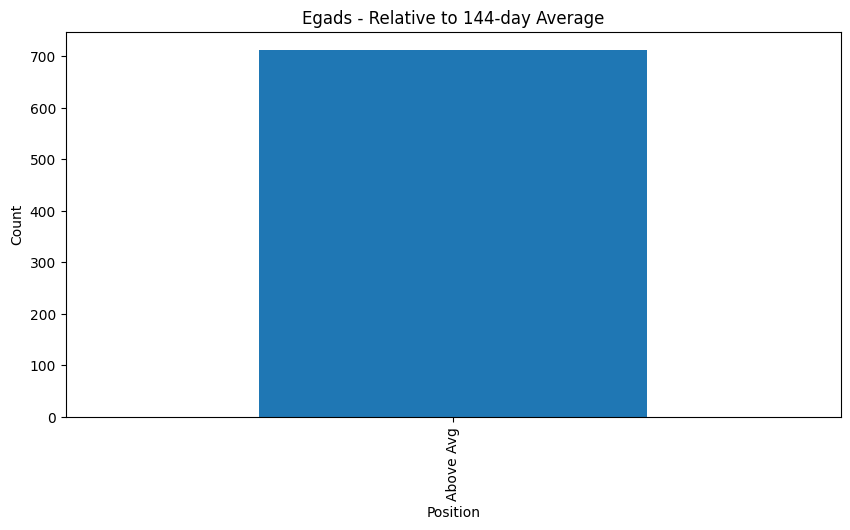

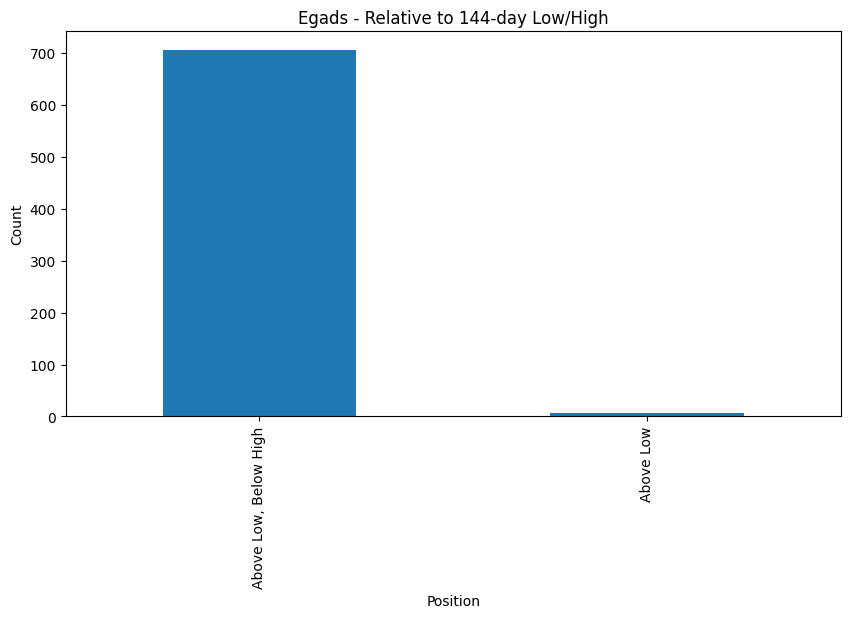

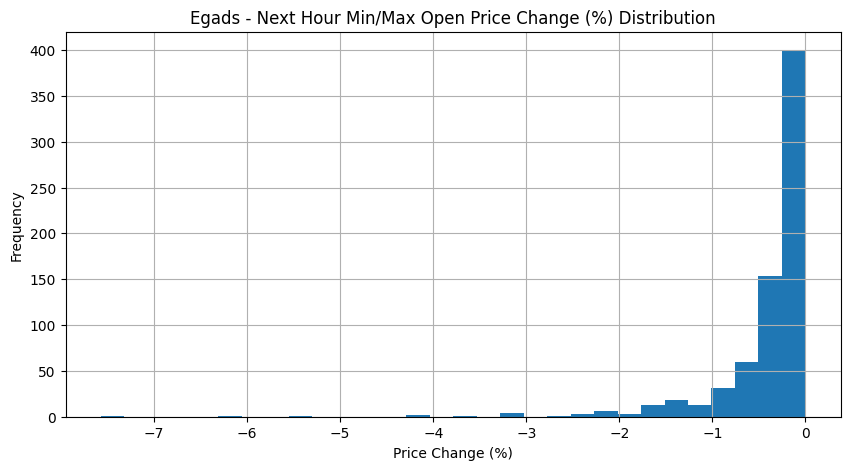

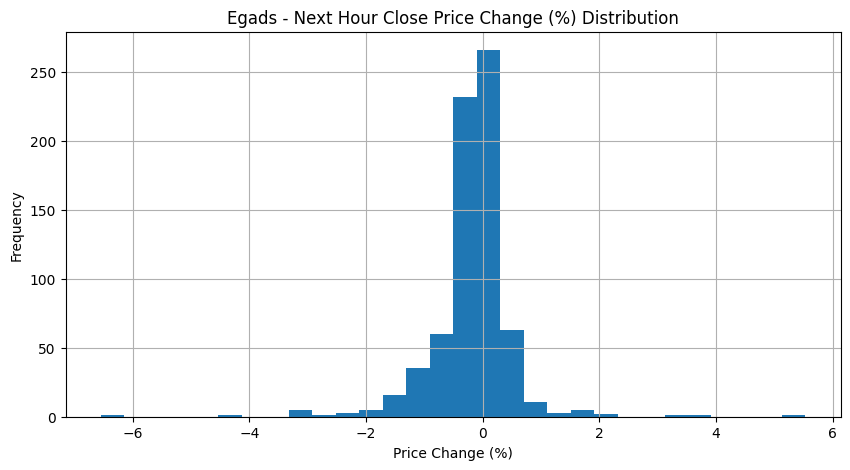

Total Merged Clusters for Trading: 608
No suitable exit found for trade starting at 2020-05-01 03:17:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-01 04:42:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-01 07:22:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-01 11:26:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-01 21:39:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-02 02:05:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-02 18:08:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-02 20:37:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-03 00:31:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-03 01:35:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-03 02:39:00. Skipping trade.
No suitable exit found for trade starting at 2020-05-03 06:

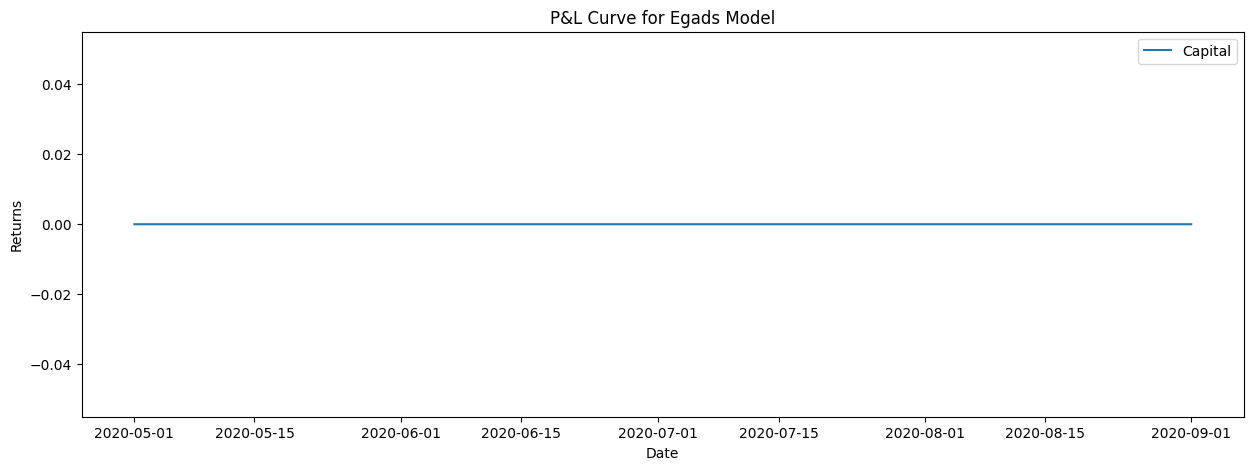

Final Capital for egads: 1.0000


In [36]:
for model_name in model_names:
    print(f"\n=== Final Outputs for Model: {model_name} ===")
    
    combined_scores[model_name] = np.array(combined_scores[model_name])
    
    anomalies, threshold = detector.get_anomalies(combined_scores[model_name], percentile=99.5)
    combined_anomalies[model_name] = anomalies
    
    plt.figure(figsize=(15, 5))
    unscaled_prices = np.array(original_prices_buffer)
    plt.plot(combined_test_dates, unscaled_prices, label='Open Price')
    
    anomaly_dates = np.array(combined_test_dates)[anomalies]
    anomaly_prices = np.array(unscaled_prices)[anomalies]
    plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
    plt.title(f'{model_name.capitalize()} Anomaly Detection for Combined Test Period')
    plt.xlabel('Date')
    plt.ylabel(' Open Price')
    plt.legend()
    plt.show()

    analysis_results = analyze_anomalies(anomaly_dates, original_data_sorted, window_minutes=window_minutes)
    compute_statistics(analysis_results, model_name)

    if isinstance(analysis_results, pd.DataFrame) and 'start' in analysis_results.columns and 'end' in analysis_results.columns:
        clusters = list(zip(analysis_results['start'], analysis_results['end']))
    else:
        clusters = [(ts, ts) for ts in anomaly_dates]
    
    merge_threshold = 40  
    merged_clusters = merge_anomaly_clusters(clusters, merge_threshold)
    
    print(f"Total Merged Clusters for Trading: {len(merged_clusters)}")
    
    ma_window = window_minutes
    original_data_sorted['MA'] = original_data_sorted['open'].rolling(window=ma_window, min_periods=1).mean()
    
    combined_test_data = original_data_sorted.loc[combined_test_dates, 'open']
    combined_ma_data = original_data_sorted.loc[combined_test_dates, 'MA']
    
    capital_history = simulate_trading_with_clusters(
        model_name=model_name,
        merged_clusters=merged_clusters,
        price_data=combined_test_data,
        ma_data=combined_ma_data,
        window_minutes=window_minutes
    )
    
    plt.figure(figsize=(15, 5))
    plt.plot(capital_history.index, capital_history.values - 1, label='Capital')
    plt.title(f'P&L Curve for {model_name.capitalize()} Model')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()
    
    final_capital = capital_history.iloc[-1]
    print(f"Final Capital for {model_name}: {final_capital:.4f}")